In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import (
    Atlas,
    fast_hist,
    reshape_pvalues,
    vec_idx_to_mat_idx,
    z_transform_to_vec
)
from bold_dementia.data.volumes import add_volumes

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "schaeffer200"
SOFT = False
pd.options.mode.copy_on_write = True
MACRO_LABELS = True

if MACRO_LABELS:
    from bold_dementia.connectivity import plot_matrix
else:
    from bold_dementia.connectivity import plot_ordered_matrix as plot_matrix # TODO This could be better

In [8]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_synthetic"
)
print(f"Fetching data in {matrices_path}")
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer200_synthetic


In [9]:
AD_vec = np.array([z_transform_to_vec(mat, k=0) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat, k=0) for mat in control_matrices])

/bigdata/jlegrand/AD-prediction/notebooks/../bold_dementia/connectivity/matrices.py:248: RuntimeWarning: divide by zero encountered in arctanh
  return np.arctanh(vec)
/bigdata/jlegrand/AD-prediction/notebooks/../bold_dementia/connectivity/matrices.py:248: RuntimeWarning: invalid value encountered in arctanh
  return np.arctanh(vec)


(array([1.2000e+01, 8.2000e+01, 8.6600e+02, 3.8442e+04, 3.6000e+02,
        1.8600e+02, 3.7000e+01, 9.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([-1.92133026, -1.35090296, -0.78047565, -0.21004834,  0.36037896,
         0.93080627,  1.50123358,  2.07166088,  2.64208819,  3.2125155 ,
         3.7829428 ]),
 [<matplotlib.patches.Polygon at 0x7f73cef91e10>])

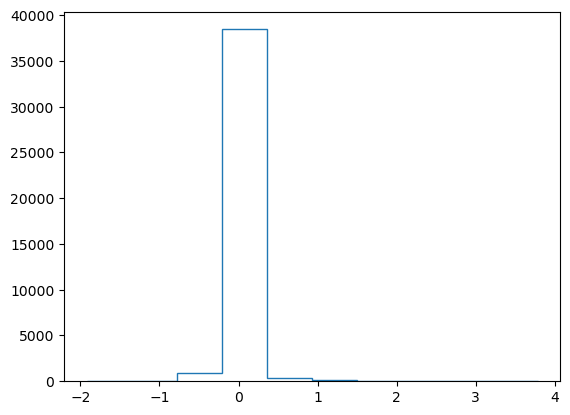

In [16]:
plt.hist(AD_matrices[0].flatten(), histtype="step")

In [10]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [14]:
fc

array([[        inf,  0.        ,         inf, ...,  0.08517035,
         0.0437183 ,         nan],
       [        inf,  0.        ,         inf, ...,  0.26255774,
         1.62551642,         nan],
       [        inf,  0.        ,         inf, ..., -0.5353426 ,
         0.70792407,         nan],
       ...,
       [        inf,  0.        ,         inf, ...,  0.73592094,
         0.94124935,         nan],
       [        inf,  0.        ,         inf, ..., -0.02771098,
         0.19876258,         nan],
       [        inf,  0.        ,         inf, ..., -0.46266766,
        -0.31618129,         nan]])

In [11]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

IndexError: index 200 is out of bounds for axis 0 with size 200

In [7]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

fc = pd.DataFrame(fc, columns=edges)

df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
df = df.drop(df[df.MA == 0].index) # Drop MA == 0
df = add_volumes(df, config["volumes"])

cleaned_df = df.dropna(subset="APOE_eps4")

IndexError: index 200 is out of bounds for axis 0 with size 200

## Visualisation of covariates 

### Age

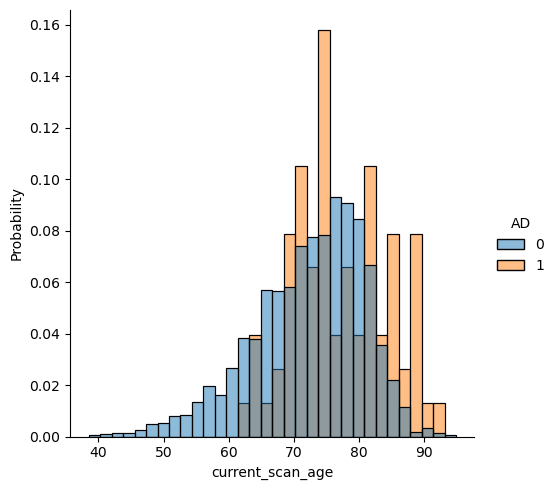

In [7]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

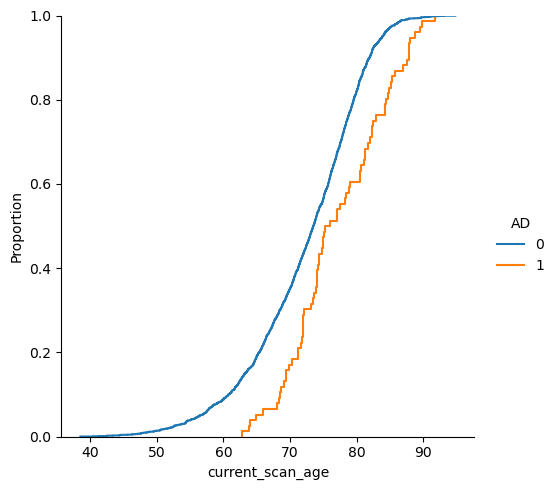

In [8]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

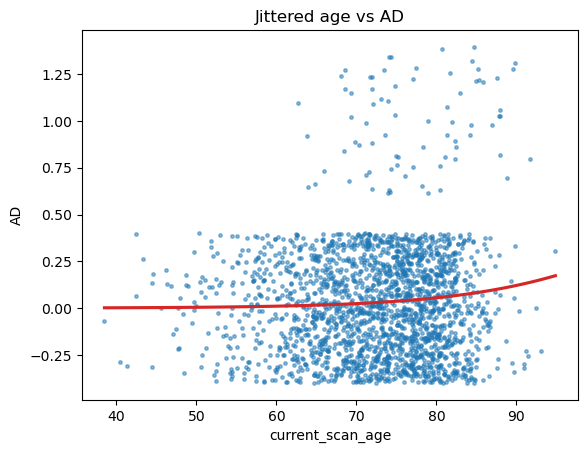

In [9]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

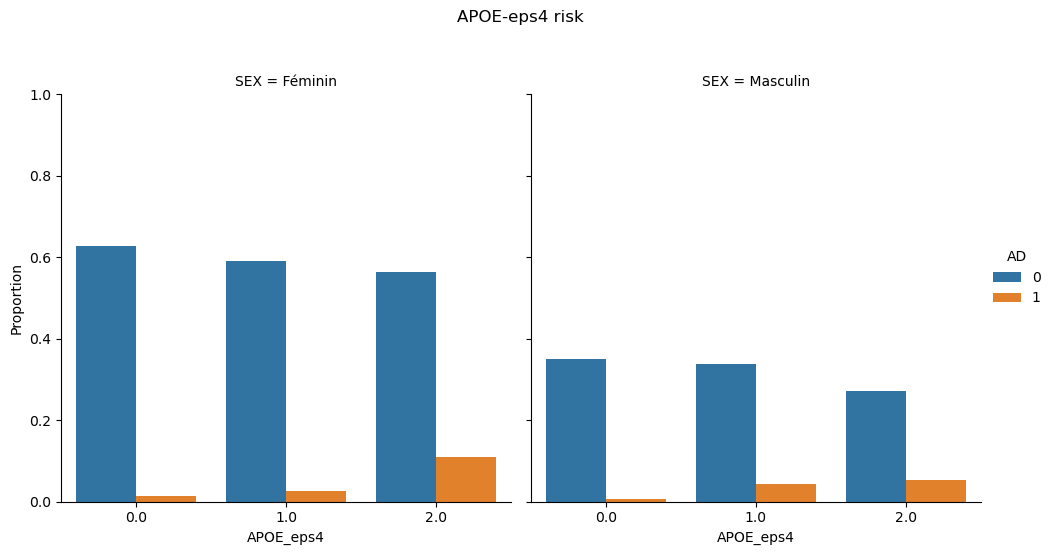

In [10]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

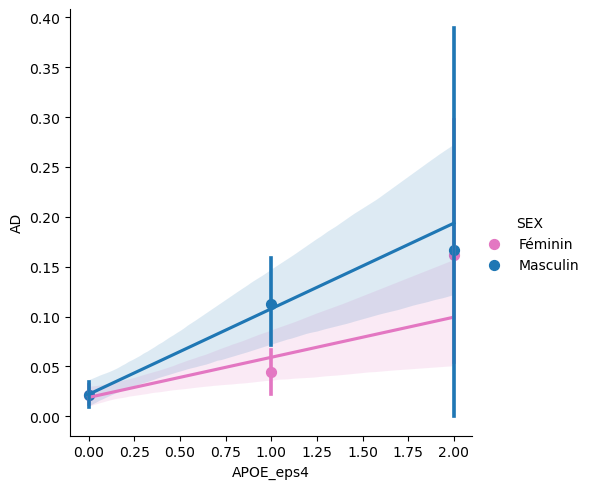

In [11]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [12]:
tst_edge_name = edges[0]
test_df = df.groupby("sub").sample(n=1).dropna(subset="NIVETUD")
lhs, rhs = model_matrix(f"`{tst_edge_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD + scale(`total intracranial`)", test_df)

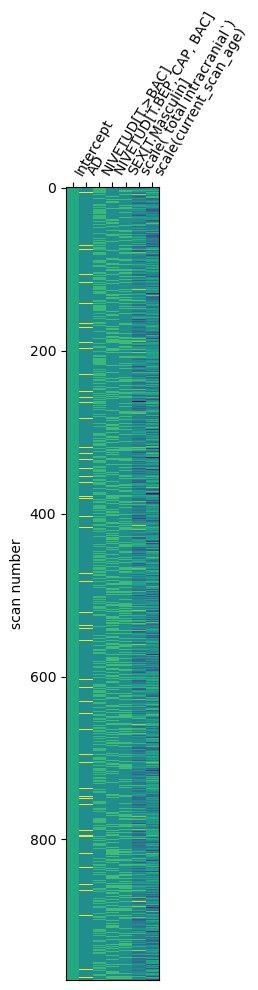

In [13]:
from nilearn import plotting

# TODO Plot design matrix
plotting.plot_design_matrix(rhs)
plotting.show()


In [14]:
import statsmodels.formula.api as smf

#model = sm.OLS(endog=lhs, exog=rhs)
model = sm.MixedLM(
    endog=lhs,
    exog=rhs,
    groups=test_df["CEN_ANOM"],
)
result = model.fit(method="bfgs")
result.summary()

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM     Dependent Variable:     RSN01_RSN02
No. Observations:       973         Method:                 REML       
No. Groups:             25          Scale:                  0.0023     
Min. group size:        1           Log-Likelihood:         1531.3813  
Max. group size:        234         Converged:              Yes        
Mean group size:        38.9                                           
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    3.096    0.005 686.999 0.000  3.088  3.105
AD                          -0.012    0.007  -1.745 0.081 -0.025  0.001
NIVETUD[T.>BAC]              0.006    0.004   1.489 0.136 -0.002  0.014
NIVETUD[T.BEP, CAP, BAC]     0.001    0.004   0.186 0.853 -0.007  0.009
SEX[T.Masculin]              0.001    0.004   0.245 0.806 -0.007  0.009
scale(`total intracranial`)  0.000    0.002   0.077 0.938 -0.004  0.004
scale(current_scan_age)     -0.000    0.002  -0.266 0.790 -0.004  0.003
Group Var                    0.000    0.002                            
=======================================================================

"""

In [15]:
# TODO Return more fitting info
# TODO CEN_ANOM as random effect?
def fit_edges(ROI_name, dataframe):
    lhs, rhs = model_matrix(f"`{ROI_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD", dataframe)
    model = sm.MixedLM(endog=lhs, exog=rhs, groups=dataframe["CEN_ANOM"])
    try:
        result = model.fit(method="bfgs") # TODO Explore method influence
        return result.params.AD, result.pvalues.AD
    except np.linalg.LinAlgError:
        return np.nan, np.nan
    

In [16]:
fit_df = lambda edge: fit_edges(edge, test_df)

In [17]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
parallel = Parallel(n_jobs=8, verbose=2)
test_results = parallel(delayed(fit_df)(edge) for edge in edges)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  

(-0.01181755540882381,)
(-0.02949552429844049, -0.011820202834792185)
(0.03135109418803642, 0.02408217393296382, -0.011824560073643893)
(0.027923774236511448, 0.03224894140033602, -0.042905926675708354, -0.01182562359282905)
(-0.014141725926203594, 0.02897787090704278, 0.011167445027986873, -0.0004514635999914763, -0.01183073764513876)
(0.03705706901097176, -0.04214049553509638, -0.011836179848637144, 0.034252501493802615, -0.030586293882400854, -0.01182662246659257)
(-0.05142807223121416, 0.012121147923780988, -0.02383890060917519, -0.027125374464238017, -0.04381530093845587, 0.05085953439670491, -0.011825661962102127)
(0.007832451176283296, -0.01007054216312607, -0.047023937495060696, 0.007365432855930533, -0.024169830492904974, 0.04955143681374028, -0.0016798074466590671, -0.011826438280074231)
(0.05071571827227374, 0.031060872815430404, -0.05491436584250063, -0.022663675921146428, -0.0026272097185185603, 0.036582249200769835, 0.028986092206367466, 0.010242083894548714, -0.011824355

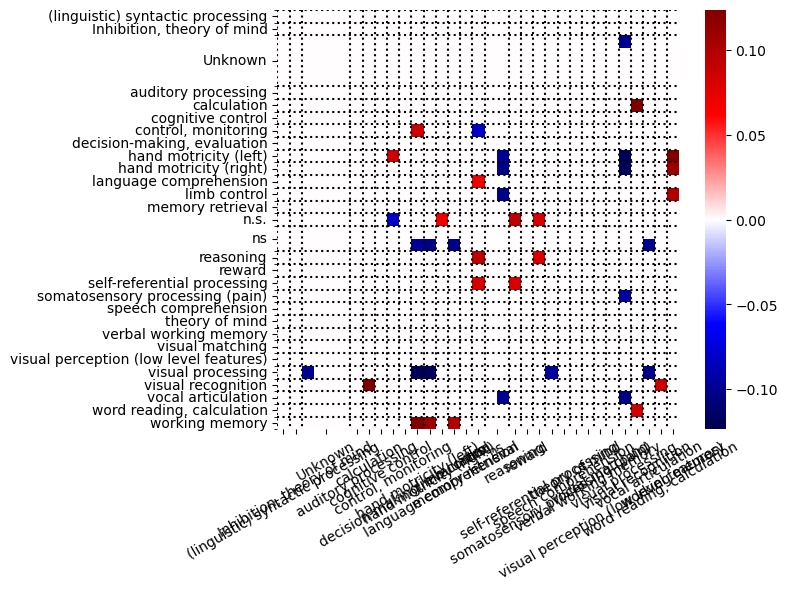

In [18]:
from bold_dementia.connectivity import plot_matrix, reshape_pvalues_with_diag

stats, pvalues = zip(*test_results)
_, pvalues_corr = fdrcorrection(pvalues)

statmat = reshape_pvalues_with_diag(stats)

pmat = reshape_pvalues_with_diag(pvalues_corr)
display_mat = np.where(pmat < config["alpha"], statmat, 0)

plot_matrix(display_mat, atlas=atlas)
plt.show()

In [35]:
dct = {
    "edges": edges,
    "beta_AD": stats,
    "pvalues_raw": pvalues,
    "pvalues_fdr": pvalues_corr
}


resdf = pd.DataFrame(dct)

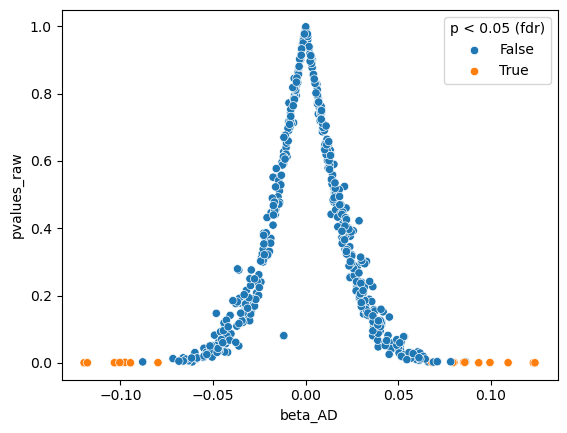

In [41]:
resdf["p < 0.05 (fdr)"] = (resdf.pvalues_fdr < 0.05)
sns.scatterplot(resdf, x="beta_AD", y="pvalues_raw", hue="p < 0.05 (fdr)")
plt.show()

In [23]:
statmat.shape

(33, 33)

In [19]:
joblib.dump(statmat, matrices_path / "EFW_glm_stat.joblib")
joblib.dump(pmat, matrices_path / "EFW_glm_pvalues.joblib")

['/homes_unix/jlegrand/data/Memento/output/connectivity/atlas-gillig_inter-networks-m5n33/EFW_glm_pvalues.joblib']

In [20]:
from nilearn import plotting
coords = atlas.get_coords()

view = plotting.view_connectome(display_mat, coords)
view.open_in_browser()

### Assumptions on residuals

In [21]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result)

AttributeError: 'MixedLMResults' object has no attribute 'mse_resid'

#### Normality

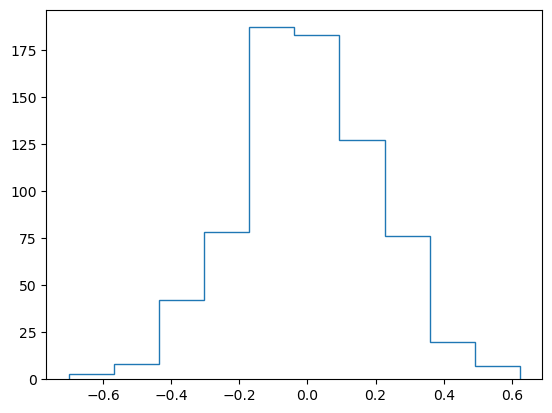

In [ ]:
plt.hist(result.resid, histtype="step")
plt.show()

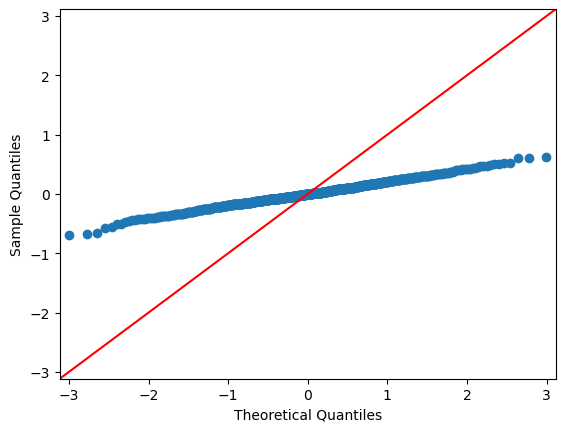

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(influence.resid, line="45")
plt.show()

#### Homoskedasticity

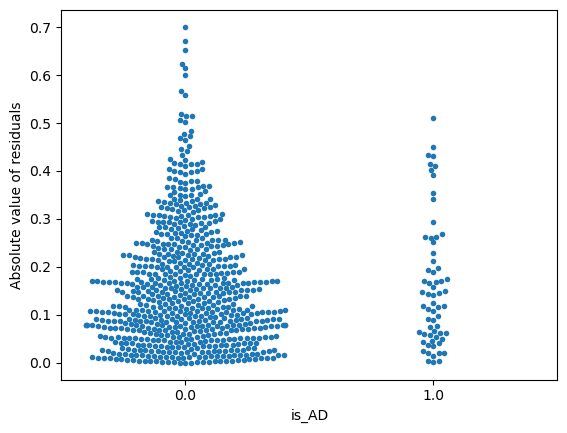

In [ ]:
# Spread Location plot
sns.swarmplot(
    x=model.exog[:, 1],
    y=abs(result.resid),
    size=4
)
plt.xlabel("is_AD")
plt.ylabel("Absolute value of residuals")
plt.show()

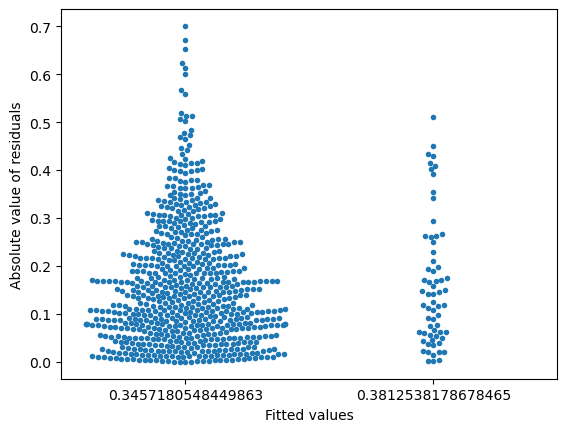

In [ ]:
sns.swarmplot(
    x=result.fittedvalues,
    y=abs(result.resid),
    size=4
)
plt.xlabel("Fitted values")
plt.ylabel("Absolute value of residuals")
plt.show()

#### Linearity

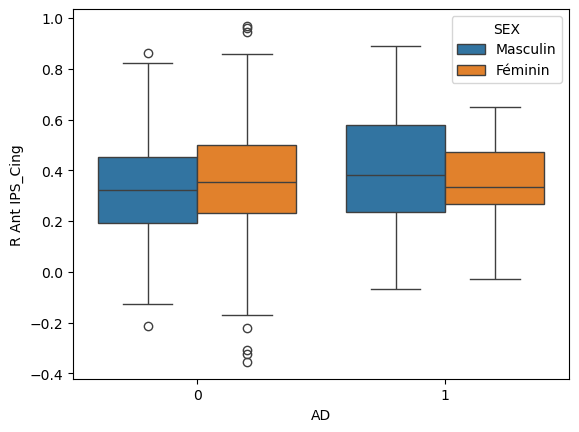

In [ ]:
# Linearity holds for categorical features
sns.boxplot(
    df,
    x="AD",
    y=tst_edge_name,
    hue="SEX"
)
plt.show()